In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import csv
from scipy.ndimage import gaussian_filter1d

Active cases map today: 
https://coronavirus.jhu.edu/map.html

<img src="active_cases_map.png" width="500" align="center">

In [3]:
# The SIR model differential equations.
def SIRdot(Y, t, N, a, b):
    S, I, R = Y
    dSdt = -a * S * I / N
    dIdt = a * S * I / N - b * I
    dRdt = b * I
    
    return dSdt, dIdt, dRdt


def SIRsol_with_param_gradients(SIRdot, t, S0, I0, R0, a, b):
    # Compute solution 5 times:  [a, b], [a+da,b], [a-da,b], [a, b+db], [a, b-db]
    # Then compute gradient wrt a, b, at each t
    Y0 = S0, I0, R0
    N = S0+I0+R0
    da = min(0.1,a/10)
    db = min(0.1,b/10)
    
    sol = odeint(SIRdot, Y0, t, args=(N, a, b))
    S, I, R = sol.T

    sol = odeint(SIRdot, Y0, t, args=(N, a+da, b))
    Sap, Iap, Rap = sol.T
 
    sol = odeint(SIRdot, Y0, t, args=(N, a-da, b))
    Sam, Iam, Ram = sol.T

    sol = odeint(SIRdot, Y0, t, args=(N, a, b+db))
    Sbp, Ibp, Rbp = sol.T
 
    sol = odeint(SIRdot, Y0, t, args=(N, a, b-db))
    Sbm, Ibm, Rbm = sol.T

    dIda = (Iap-Iam)/(2*da)
    dIdb = (Ibp-Ibm)/(2*db)
    
    #return S, I, R, dIda, dIdb
    return I, dIda, dIdb

In [4]:
def GaussIter(t, Idata, S0, I0, R0, a0, b0):
    tol = .01
    NiterMax = 500
    
    a, b = a0, b0
    Da, Db = 1, 1
    
    fig = plt.figure(facecolor='w')
    plt.plot(t, Idata, 'b.', label='Data')
    
    Niter = 0
    while np.sqrt((Da)**2+(Db)**2) > tol and Niter < NiterMax:
        Niter += 1
        It, dIda, dIdb = SIRsol_with_param_gradients(SIRdot, t, S0, I0, R0, a, b)
        DI = Idata-It
        J = np.vstack((dIda,dIdb)).T
        Da,Db = np.linalg.inv(J.T.dot(J)).dot(J.T.dot(DI))
        a = a+Da
        b = b+Db
        
        plt.plot(t, It, alpha=0.5, lw=2, label='Model fit')
        
    plt.xlabel('Time /days')
    plt.ylabel('Infected population')
    plt.grid()
    plt.legend()
    return It, a, b, Niter, dIda, dIdb

In [5]:
def prepare_data( loc_type, loc_name, cutoff=0 ):
    
    confirmed = [] 
    death = []
    recovered = []
    # reading csv file 
    with open("confirmed_global.csv", 'r') as csvfile: 
        csvreader = csv.reader(csvfile) 
        for row in csvreader: 
            confirmed.append(row)
    with open("deaths_global.csv",'r') as csvfile:
        csvreader = csv.reader(csvfile) 
        for row in csvreader: 
            death.append(row)
    with open("recovered_global.csv",'r') as csvfile:
        csvreader = csv.reader(csvfile) 
        for row in csvreader: 
            recovered.append(row)
        
    
    confirmed = np.asarray(confirmed)
    death = np.asarray(death)
    recovered = np.asarray(recovered)
    
    idx = np.where(confirmed[:,loc_type] == loc_name) #
    if (loc_type == 1) & (np.shape(idx)[0] > 1):
        idx = np.where( (confirmed[:,loc_type] == loc_name) & (confirmed[:,0]=='') )#        
    idx = idx[0]   
    confirmed = confirmed[idx, 4:np.shape(confirmed)[1]  ]
    
    
    idx = np.where(death[:,loc_type] == loc_name) #
    if (loc_type == 1) & (np.shape(idx)[0] > 1):
        idx = np.where( (death[:,loc_type] == loc_name) & (death[:,0]=='') )#        
    idx = idx[0]  
    death = death[idx, 4:np.shape(death)[1]  ]

    idx = np.where(recovered[:,loc_type] == loc_name) #
    
    if (loc_type == 1) & (np.shape(idx)[0] > 1):
        idx = np.where( (recovered[:,loc_type] == loc_name) & (recovered[:,0]=='') )#        
    idx = idx[0]  
    recovered = recovered[idx, 4:np.shape(recovered)[1]  ]
    
    confirmed = confirmed[0].astype(np.float)
    death = death[0].astype(np.float)
    recovered = recovered[0].astype(np.float)
    #print(confirmed)
    # Look for the first day that confirmed cases appeared, and take it as the initial condition:
    start = np.where(confirmed > cutoff)
    #print(start)
    # Current length of the time series:
    T = np.shape(confirmed)[0]
    # Exclude the zeros in the time series, so it will have a nonzero initial condition:
    confirmed = confirmed[start[0][0]:T]
    death = death[ start[0][0]:T ]
    recovered = recovered[ start[0][0]:T ]
    # Current length of the time series:
    T = T - start[0][0]
    return confirmed, death, recovered, T

In [6]:
loc_type = 0 # type of location: 0 for state/province, 1 for country/region;
loc_name = 'Hubei' # name of location: e.g. 'Japan', 'Italy', etc
cutoff = 0 # The data before the confirmed cases reach this number will be discarded 
confirmed, death, recovered, T = prepare_data(loc_type,loc_name,cutoff)
# The infectious population is then : #I = confirmed cases - (#deaths + #recovered)
I = confirmed - death - recovered
R = death + recovered
# filter the data so it is smoother
#I = gaussian_filter1d(I,1)
t = np.arange(T)

N = 58.5*1000000 # population of Hubei on wikipedia...
#N = 126.5*1000000 # population of Japan
#N = 81.8*1000000 # Population of Iran

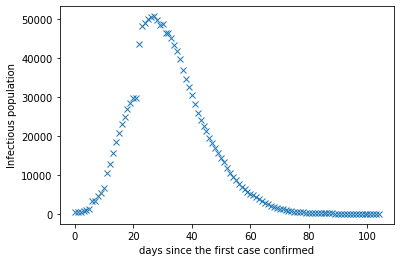

In [7]:
plt.plot(t,I,'x')
#plt.plot(t,death,'.',label = 'deaths')
#plt.plot(t,confirmed,'*',label = 'confirmed')
#plt.plot(t,recovered,'+',label = 'recovered')
plt.xlabel('days since the first case confirmed')
plt.ylabel('Infectious population')
plt.show()

(4.720780049601624, 4.503129041857981, 13)

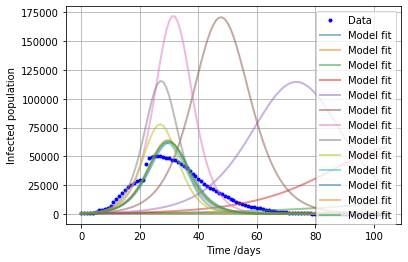

In [8]:
#Initial R component: #deaths + #recovered
R0 = death[0]+recovered[0]
I0 = I[0]
S0 = N - I0 - R0
a0 = 1
b0 = 1
It, dIda, dIdb = SIRsol_with_param_gradients(SIRdot, t, S0, I0, R0, a0, b0)
It, at, bt, Niter, dIda, dIdb = GaussIter(t, I, S0, I0, R0, a0, b0)
at, bt, Niter

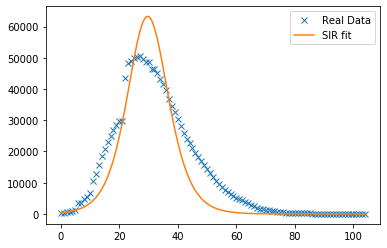

In [9]:
plt.plot(t,I,'x',label = 'Real Data')

plt.plot(t,It,label = 'SIR fit')
plt.legend()
plt.show()

In [10]:
# Reproductive number:
at/bt*S0/N

1.0483253258369285

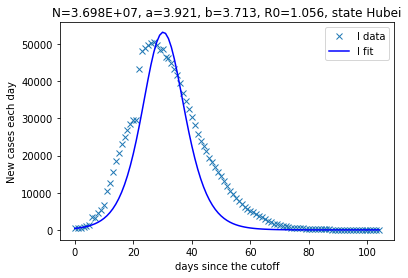

In [18]:
import scipy
N = 58.5*1E6
def SIR_deriv(X,t,N,a,b):
    S,I,R = X
    return -a/N*I*S, a/N*I*S-b*I, b*I


I0 = I[0]
R0 = R[0]
def SIR(t,N,a,b):
    X0 = N-I0-R0,I0,R0

    # Integrate the equations over the time grid, t.
    ret = scipy.integrate.odeint(SIR_deriv, X0, t, args=(N,a,b))
    S,I,R = ret.T
    return I#np.concatenate( (I, R),axis=0)


     


param = scipy.optimize.curve_fit(SIR,t,I,p0 = [N,2,1],bounds=([N/10,0,0],[2*N,100,100]))#np.concatenate((I, R),axis=0)  )

Nfit, a,b = param[0]
#print(param[0])

plt.plot(t,I,'x',label='I data')
IR = SIR(t,Nfit,a,b)
II = IR[0:len(t)]
#RR = IR[len(t):2*len(t)]
plt.plot(t,II,'b',label = 'I fit')
#plt.plot(t,R,'o',label='R data')
#plt.plot(t,RR,label='R fit')

plt.legend()
plt.xlabel('days since the cutoff')
plt.ylabel('New cases each day')
plt.title('N={:.3E}, a={:.4}, b={:.4}, R0={:.4}, state {}'.format(Nfit,a,b,a/b,loc_name))
plt.show()

In [13]:
N

58500000.0

In [19]:
Nfit

36977062.35868037